# Boris AI Denoiser

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import moviepy.editor as mpy
from skimage.metrics import peak_signal_noise_ratio

PIL images and MoviePy frames are always channels-last with RGB values in [0, 255], while tensors are always channels-first with RGB values in [0,1]. The helper functions below convert appropriately between the formats.

The function `gaussian_noise` takes single video frame as a tensor and applies Additive White Gaussian Noise to it systematically, using the standard deviation of the distribution that is passed in a parameter names noise_level. A higher standard deviation will result in a more noisy video frame, while a lower standard deviation will result in a less noisy video frame. Below is an example of an original video frame and the output of the `gaussian_noise` function when it is called with a `noise_level` (standard deviation) of 50 / 255.

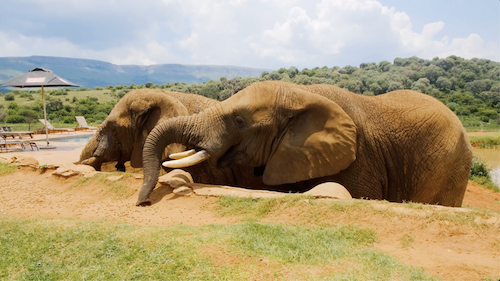

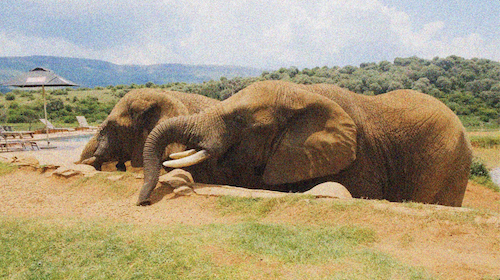

In [2]:
def tensor_from_image(image):
    array = np.asarray(image, dtype=np.float32)
    array = np.float32(array / 255.0)
    array = np.transpose(array, (2, 0, 1))
    tensor = torch.from_numpy(array)
    return tensor

def image_from_tensor(tensor):
    array = np.asarray(tensor, dtype=np.float32)
    array = np.transpose(array, (1, 2, 0))
    array = np.uint8(array * 255.0)
    image = Image.fromarray(array)
    return image

def tensor_from_frame(frame):
    array = np.asarray(frame, dtype=np.float32)
    array = (array / 255.0)
    tensor = torch.from_numpy(array)
    return np.transpose(tensor, (2, 0, 1))
    
def frame_from_tensor(tensor):
    array = np.asarray(tensor, dtype=np.float32)
    array = np.transpose(array, (1, 2, 0))
    array = (array * 255)
    return array

def gaussian_noise(tensor, noise_level):
    array = np.copy(np.asarray(tensor, dtype=np.float32))
    channels, height, width = array.shape
    mean = 0
    std = noise_level
    gauss = np.random.normal(mean, std, (channels, height, width))
    array += gauss
    np.clip(array, 0, 1, out=array)
    array = array.astype(np.float32)
    tensor = torch.from_numpy(array)
    return tensor


Below is the definition of the Boris AI Denoiser, implemented with PyTorch. The model accepts 5 consecutive frames and a noise map as input. For each noisy frame, the input to the model includes the frame itself, the two frames preceeding it, and the two frames after it. The use of 5 consecutive frames is necessary for temporal coherance (avoids flickering). The final input to the model is a (1x96x96) tensor filled with the standard deviation(std is the sigma value divided by 255 and is referred to as noise_level), so that the model can learn the amount of noise that has been added. This allows for denoising of a variety of videos with different noise levels in prediction. The output of the model is the denoised current frame.

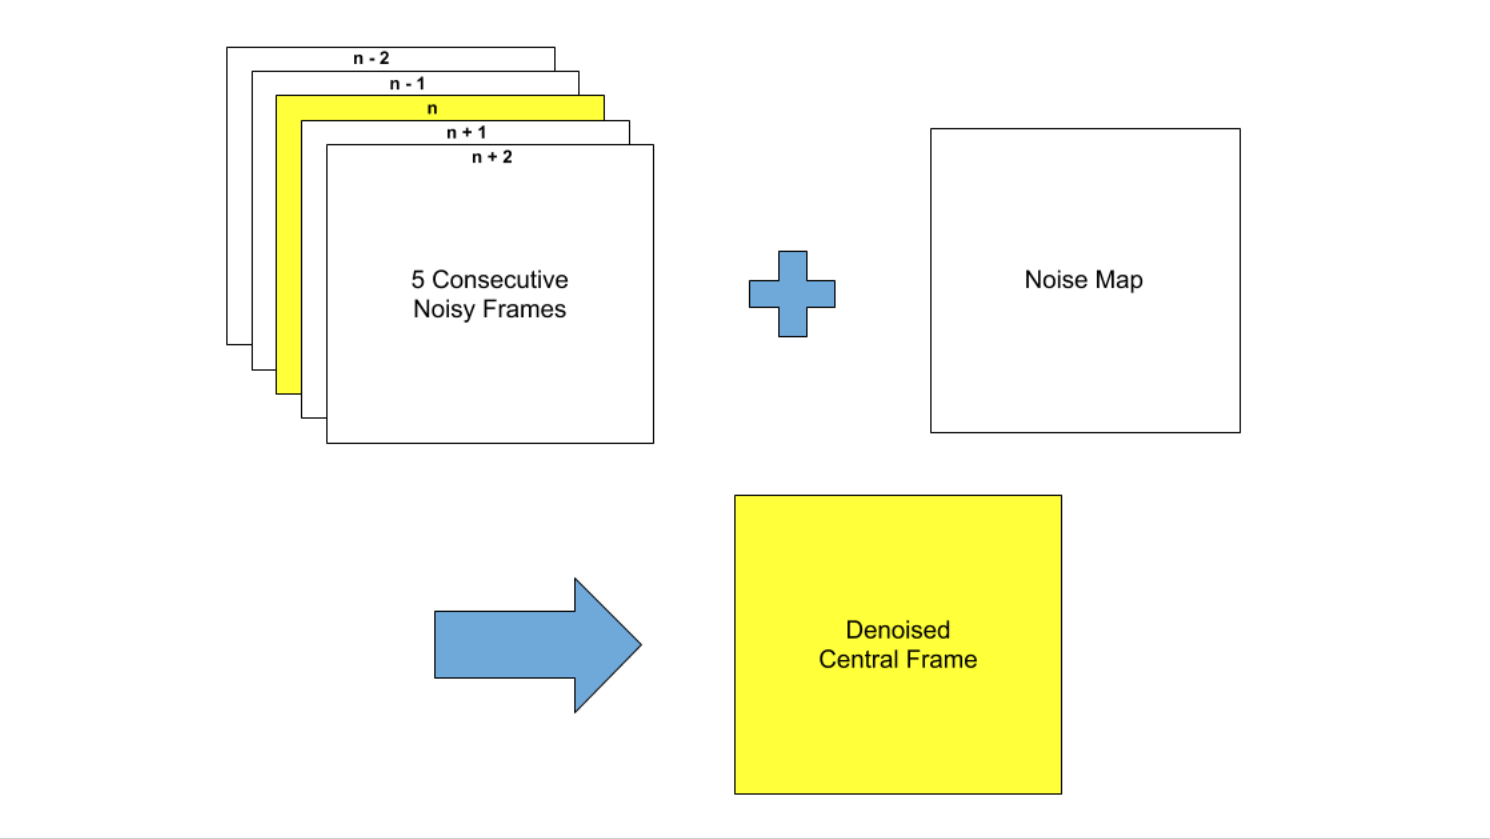

In [3]:
class CvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(CvBlock, self).__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.convblock(x)

class InputCvBlock(nn.Module):
    def __init__(self, num_in_frames, out_ch):
        super(InputCvBlock, self).__init__()
        self.interm_ch = 30
        self.convblock = nn.Sequential(
            nn.Conv2d(num_in_frames*(3+1), num_in_frames*self.interm_ch, \
                      kernel_size=3, padding=1, groups=num_in_frames, bias=False),
            nn.BatchNorm2d(num_in_frames*self.interm_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_in_frames*self.interm_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.convblock(x)

class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DownBlock, self).__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            CvBlock(out_ch, out_ch)
        )

    def forward(self, x):
        return self.convblock(x)

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UpBlock, self).__init__()
        self.convblock = nn.Sequential(
            CvBlock(in_ch, in_ch),
            nn.Conv2d(in_ch, out_ch*4, kernel_size=3, padding=1, bias=False),
            nn.PixelShuffle(2)
        )

    def forward(self, x):
        return self.convblock(x)

class OutputCvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutputCvBlock, self).__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(in_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        return self.convblock(x)

class DenBlock(nn.Module):
    def __init__(self, num_input_frames=3):
        super(DenBlock, self).__init__()
        self.chs_lyr0 = 32
        self.chs_lyr1 = 64
        self.chs_lyr2 = 128
        self.inc = InputCvBlock(num_in_frames=num_input_frames, out_ch=self.chs_lyr0)
        self.downc0 = DownBlock(in_ch=self.chs_lyr0, out_ch=self.chs_lyr1)
        self.downc1 = DownBlock(in_ch=self.chs_lyr1, out_ch=self.chs_lyr2)
        self.upc2 = UpBlock(in_ch=self.chs_lyr2, out_ch=self.chs_lyr1)
        self.upc1 = UpBlock(in_ch=self.chs_lyr1, out_ch=self.chs_lyr0)
        self.outc = OutputCvBlock(in_ch=self.chs_lyr0, out_ch=3)
        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

    def reset_params(self):
        for _, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, in0, in1, in2, noise_map):
        x0 = self.inc(torch.cat((in0, noise_map, in1, noise_map, in2, noise_map), dim=1))
        x1 = self.downc0(x0)
        x2 = self.downc1(x1)
        x2 = self.upc2(x2)
        x1 = self.upc1(x1+x2)
        x = self.outc(x0+x1)
        x = in1 - x

        return x

class BorisFXAIDenoiser(nn.Module):

    def __init__(self, num_input_frames=5):
        super(BorisFXAIDenoiser, self).__init__()
        self.num_input_frames = num_input_frames
        # Define models of each denoising stage
        self.temp1 = DenBlock(num_input_frames=3)
        self.temp2 = DenBlock(num_input_frames=3)
        # Init weights
        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

    def reset_params(self):
        for _, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x0, x1, x2, x3, x4, noise_map):
        x20 = self.temp1(x0, x1, x2, noise_map)
        x21 = self.temp1(x1, x2, x3, noise_map)
        x22 = self.temp1(x2, x3, x4, noise_map)
        x = self.temp2(x20, x21, x22, noise_map)
        return x

## Train

In [ ]:
# CREATE NEW MODEL
model = BorisFXAIDenoiser()
model = model.cuda()

The code below inherits from PyTorch's Dataloader class and loads the video frames to be used for training. This dataloader is specific to the structure of the dataset that results from running `dataset.ipynb`. All frames are read as PIL images then covnerted to tensors and noisified using the `gaussian_noise` function. For each call to this class, the dataloader returns the original 5 consecutive frames, the noisy versions of those frames, and a tensor representation of the standard deviation of the noise. 

In [ ]:
fps = 24
fpm = 48

batch_size = 96
num_workers = 16
# sigma will be within [5,50], dividing by 255 gives us the standard deviation(called noise_level). A higher standard deviation is more noisy.
noise_min = 5 / 255
noise_max = 50 / 255
crop_size = 96

class NoisyData(Dataset):
    def __init__(self, directory):
        self.directory = directory
        self.paths = os.listdir(self.directory)

    def __len__(self):
        # returns the total number of frames in the directory so that the dataloader is called for each frame
        num_cropped_movies = len(os.listdir(self.directory))
        num_frames = fpm * num_cropped_movies
        return num_frames
    
    def __getitem__(self, index):
        noise_level = np.random.uniform(noise_min, noise_max)
        cropped_movie_index = index // fpm
        current_frame_index = index % fpm
        # get the indices of the 2 frames before and the 2 frames after the current frame
        sub_two_frame_index = max(0, current_frame_index - 2)   
        sub_one_frame_index = max(0, current_frame_index - 1) 
        add_one_frame_index = min(current_frame_index + 1, fpm - 1) 
        add_two_frame_index = min(current_frame_index + 2, fpm - 1)
        
        # get the name of each frame's file based on the index
        sub_two_frame_name = '%02d' % sub_two_frame_index
        sub_one_frame_name = '%02d' % sub_one_frame_index
        current_frame_name = '%02d' % current_frame_index
        add_one_frame_name = '%02d' % add_one_frame_index
        add_two_frame_name = '%02d' % add_two_frame_index
        
        # the noise_map is a tensor passed to the model where each element is equal to the noise_level(standard deviation of the noise)
        noise_map = torch.full((1, crop_size, crop_size), noise_level)
        
        # read 5 consecutive frames as PIL images and convert to tensors
        sub_two_tensor = tensor_from_image(Image.open(os.path.join(self.directory, self.paths[cropped_movie_index], sub_two_frame_name + '.png')))
        sub_one_tensor = tensor_from_image(Image.open(os.path.join(self.directory, self.paths[cropped_movie_index], sub_one_frame_name + '.png')))
        current_tensor = tensor_from_image(Image.open(os.path.join(self.directory, self.paths[cropped_movie_index], current_frame_name + '.png')))
        add_one_tensor = tensor_from_image(Image.open(os.path.join(self.directory, self.paths[cropped_movie_index], add_one_frame_name + '.png')))
        add_two_tensor = tensor_from_image(Image.open(os.path.join(self.directory, self.paths[cropped_movie_index], add_two_frame_name + '.png')))
        
        # add noise with the same noise level(standard deviation) to all 5 tensors
        sub_two_noisy = gaussian_noise(sub_two_tensor, noise_level)
        sub_one_noisy = gaussian_noise(sub_one_tensor, noise_level)
        current_noisy = gaussian_noise(current_tensor, noise_level)
        add_one_noisy = gaussian_noise(add_one_tensor, noise_level)
        add_two_noisy = gaussian_noise(add_one_tensor, noise_level)
        
        return (
            noise_map, 
            sub_two_tensor, sub_one_tensor, current_tensor, add_one_tensor, add_two_tensor,
            sub_two_noisy, sub_one_noisy, current_noisy, add_one_noisy, add_two_noisy,
        )

trainloader = torch.utils.data.DataLoader(
    NoisyData(directory='datasets/denoise'), 
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
)

This training loop calls the trainloader, unpacks the output and sends all input to the GPU, and trains the model using Mean Squared Error loss function and the Adam optimizer.

In [ ]:
#set hyperparameters
num_epochs = 7
learning_rate = 1e-6

loss_fn = nn.MSELoss()
loss_fn.cuda()
model = model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
running_loss = 0

# training loop
for epoch in range(num_epochs):
    for batch_index, data in enumerate(trainloader):
        # separate the output of the dataloader
        noise_map, original_tensors, input_tensors = data[0], data[1:6], data[6:11]
        # send all input tensors to the GPU
        sub_two_noisy, sub_one_noisy, current_noisy, add_one_noisy, add_two_noisy = (
            input_tensors[0].cuda(non_blocking=True), 
            input_tensors[1].cuda(non_blocking=True),
            input_tensors[2].cuda(non_blocking=True),
            input_tensors[3].cuda(non_blocking=True),
            input_tensors[4].cuda(non_blocking=True)
        )
        # send all original tensors to the GPU 
        sub_two_tensor, sub_one_tensor, current_tensor, add_one_tensor, add_two_tensor = (
            original_tensors[0].cuda(non_blocking=True),
            original_tensors[1].cuda(non_blocking=True),
            original_tensors[2].cuda(non_blocking=True),
            original_tensors[3].cuda(non_blocking=True),
            original_tensors[4].cuda(non_blocking=True)
        )
        # send noise_map to the GPU
        noise_map = noise_map.cuda(non_blocking=True)
        
        optimizer.zero_grad()
        output_tensor = model(sub_two_noisy, sub_one_noisy, current_noisy, add_one_noisy, add_two_noisy, noise_map)
        loss = loss_fn(output_tensor, current_tensor)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_index > 0 and batch_index % 1 == 0:    
            print(
                'epoch %d / %d batch %d / %d loss %.10f' % 
                (epoch + 1, num_epochs, batch_index, len(trainloader), running_loss / batch_size)
            )
            running_loss = 0.0

In [ ]:
# SAVE MODEL
path = 'Denoiser.pth'
torch.save(model.state_dict(), path)

## Make Predictions with Python

In [4]:
# LOAD MODEL
model = BorisFXAIDenoiser()
model = model.cuda()
path = 'models/Denoiser.pth'
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
model = model.eval()

#### Noisify Clean Video and Predict

This block of code accepts a clean video, adds noise to it based on the user's chosen noise level, and makes a prediction. This is useful for testing purposes so that PSNR or MSE can be calculated between the original and the output video. 

In [5]:
with torch.no_grad():
    movie = mpy.VideoFileClip('datasets/2k_video_clips/58.mp4')
    fpm = round(movie.fps * movie.duration)
    input_frames = []
    output_frames = []
    # noisify each frame with sigma 50(sigma divided by 255 is standard deviation)
    noise_level = 50 / 255
    baseline_loss = 0
    loss = 0
    psnr = []
    baseline_psnr = []
    for frame_index in range(fpm):
        t = frame_index / movie.fps
        
        sub_two_frame_index = max(0, frame_index - 2)
        sub_two_frame_t = sub_two_frame_index / movie.fps
        sub_one_frame_index = max(0, frame_index - 1)
        sub_one_frame_t = sub_one_frame_index / movie.fps
        add_one_frame_index = min(frame_index + 1, (fpm - 1))
        add_one_frame_t = add_one_frame_index / movie.fps
        add_two_frame_index = min(frame_index + 2, (fpm - 1))
        add_two_frame_t = add_two_frame_index / movie.fps
        
        sub_two_noisy = gaussian_noise(tensor_from_frame(movie.get_frame(sub_two_frame_t)), noise_level)
        sub_one_noisy = gaussian_noise(tensor_from_frame(movie.get_frame(sub_one_frame_t)), noise_level)
        current_noisy = gaussian_noise(tensor_from_frame(movie.get_frame(t)), noise_level)
        add_one_noisy = gaussian_noise(tensor_from_frame(movie.get_frame(add_one_frame_t)), noise_level)
        add_two_noisy = gaussian_noise(tensor_from_frame(movie.get_frame(add_two_frame_t)), noise_level)
        
        input_frames.append(frame_from_tensor(current_noisy))
        channels, height, width = current_noisy.shape
        noise_map = torch.full((1, 1, height, width), noise_level)
        output_tensor = model(torch.unsqueeze(sub_two_noisy, 0).cuda(),
                              torch.unsqueeze(sub_one_noisy, 0).cuda(), 
                              torch.unsqueeze(current_noisy, 0).cuda(), 
                              torch.unsqueeze(add_one_noisy, 0).cuda(), 
                              torch.unsqueeze(add_two_noisy, 0).cuda(),
                              noise_map.cuda()).cpu()[0]
        
        output_tensor = np.clip(output_tensor, 0, 1)
        output_frames.append(frame_from_tensor(output_tensor))
        
        current_tensor = tensor_from_frame(movie.get_frame(t))
        baseline_loss += ((current_noisy - current_tensor) ** 2).mean().item()
        loss += ((output_tensor - current_tensor) ** 2).mean().item()
        baseline_psnr.append(peak_signal_noise_ratio(image_true=np.asarray(current_tensor), image_test=np.asarray(current_noisy)))
        psnr.append(peak_signal_noise_ratio(image_true=np.asarray(current_tensor), image_test=np.asarray(output_tensor)))
        
    input_video = mpy.ImageSequenceClip(input_frames, fps=movie.fps)
    output_video = mpy.ImageSequenceClip(output_frames, fps=movie.fps)

In [ ]:
output_video.write_videofile('outputs/denoised_video_sigma50.mp4')

Shown below is a single frame of the input and output videos from the above prediction block:

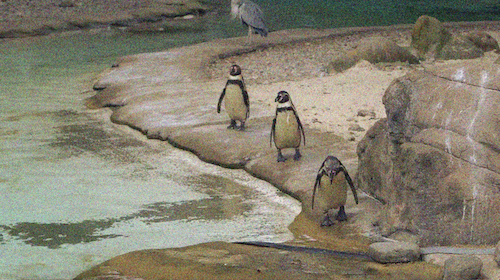

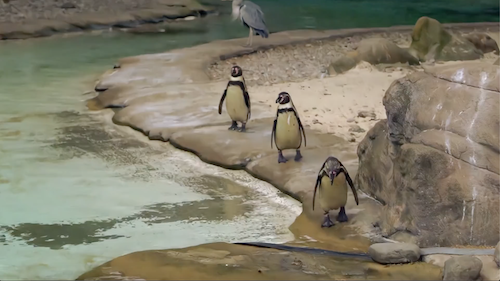

#### Predict on Noisy Video

This block of code accepts an originaly noisy video, where the user supplies an estimate of the noise level present, and denoises it.

In [ ]:
with torch.no_grad():
    movie = mpy.VideoFileClip('videos/boat.mov')
    fpm = round(movie.fps * movie.duration)
    input_frames = []
    output_frames = []
    # estimate the sigma of the video(sigma divided by 255 is standard deviation)
    noise_level = 50 / 255

    for frame_index in range(fpm):
        t = frame_index / movie.fps
        
        sub_two_frame_index = max(0, frame_index - 2)
        sub_two_frame_t = sub_two_frame_index / movie.fps
        sub_one_frame_index = max(0, frame_index - 1)
        sub_one_frame_t = sub_one_frame_index / movie.fps
        add_one_frame_index = min(frame_index + 1, (fpm - 1))
        add_one_frame_t = add_one_frame_index / movie.fps
        add_two_frame_index = min(frame_index + 2, (fpm - 1))
        add_two_frame_t = add_two_frame_index / movie.fps
        
        sub_two_noisy = tensor_from_frame(movie.get_frame(sub_two_frame_t))
        sub_one_noisy = tensor_from_frame(movie.get_frame(sub_one_frame_t))
        current_noisy = tensor_from_frame(movie.get_frame(t))
        add_one_noisy = tensor_from_frame(movie.get_frame(add_one_frame_t))
        add_two_noisy = tensor_from_frame(movie.get_frame(add_two_frame_t))
        
        input_frames.append(frame_from_tensor(current_noisy))
        channels, height, width = current_noisy.shape
        noise_map = torch.full((1, 1, height, width), noise_level)
        output_tensor = model(
            torch.unsqueeze(sub_two_noisy, 0).cuda(),
            torch.unsqueeze(sub_one_noisy, 0).cuda(), 
            torch.unsqueeze(current_noisy, 0).cuda(), 
            torch.unsqueeze(add_one_noisy, 0).cuda(), 
            torch.unsqueeze(add_two_noisy, 0).cuda(),        
            noise_map.cuda()
        ).cpu()[0]
        
        output_tensor = np.clip(output_tensor, 0, 1)
        output_frames.append(frame_from_tensor(output_tensor))
  
    input_video = mpy.ImageSequenceClip(input_frames, fps=movie.fps)
    output_video = mpy.ImageSequenceClip(output_frames, fps=movie.fps)

In [ ]:
output_video.write_videofile('outputs/denoised_boat_sigma50')

## Convert to CoreML

The following code converts a trained PyTorch model to Apple's Core ML format using the coremltools library.

In [ ]:
import coremltools as ct
import coremltools.proto.FeatureTypes_pb2 as ft 
from coremltools.models.neural_network import flexible_shape_utils

In [ ]:
# load PyTorch model in eval mode
torch_model = BorisFXAIDenoiser()
torch_model_path = 'models/Denoiser.pth'
torch_model.load_state_dict(torch.load(torch_model_path, map_location='cpu'))
torch_model = torch_model.eval()

In [ ]:
# trace PyTorch model
example_inputs = (
    torch.rand(1, 3, 96, 96), 
    torch.rand(1, 3, 96, 96), 
    torch.rand(1, 3, 96, 96), 
    torch.rand(1, 3, 96, 96), 
    torch.rand(1, 3, 96, 96), 
    torch.full((1, 1, 96, 96), .01)
)
traced_model = torch.jit.trace(torch_model, example_inputs)

In [ ]:
# define inputs and do conversion to Core ML
inputs = [
    ct.TensorType(name='inputFrameSubTwo', shape=(-1, 3, -1, -1)), 
    ct.TensorType(name='inputFrameSubOne', shape=(-1, 3, -1, -1)), 
    ct.TensorType(name='inputFrameCurrent', shape=(-1, 3, -1, -1)),
    ct.TensorType(name='inputFrameAddOne', shape=(-1, 3, -1, -1)), 
    ct.TensorType(name='inputFrameAddTwo', shape=(-1, 3, -1, -1)), 
    ct.TensorType(name="noiseMap", shape=(-1, 1, -1, -1)),
]
coreml_model = ct.convert(traced_model, inputs=inputs)
coreml_model.save('models/Denoiser.mlmodel')

In [ ]:
# make a prediction with Core ML model in Python
coreml_model = ct.models.MLModel('models/Denoiser.mlmodel')
predictions = coreml_model.predict({
    'inputFrameSubTwo': torch.unsqueeze(tensor_from_image(Image.open("datasets/denoise/00-000/00.png")), 0).numpy(),
    'inputFrameSubOne': torch.unsqueeze(tensor_from_image(Image.open("datasets/denoise/00-000/01.png")), 0).numpy(),
    'inputFrameCurrent': torch.unsqueeze(tensor_from_image(Image.open("datasets/denoise/00-000/02.png")), 0).numpy(),
    'inputFrameAddOne': torch.unsqueeze(tensor_from_image(Image.open("datasets/denoise/00-000/03.png")), 0).numpy(),
    'inputFrameAddTwo': torch.unsqueeze(tensor_from_image(Image.open("datasets/denoise/00-000/04.png")), 0).numpy(),
    'noiseMap': torch.unsqueeze(torch.full((1, 96, 96), 0.02), 0).numpy(),
})
image_from_tensor(predictions['1721'][0]).show()